# Initialization

## Import libraries

In [32]:
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import ssl # Quickfix to torchaudio ssl error
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Preprocessing

## Helper Function

In [2]:
def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to 224x224
    image = image / 255.0  # Normalize to [0, 1]
    image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
    image = torch.tensor(image, dtype=torch.float32)
    return image

def show_image(dataloader, index):
    # Get a batch of data
    data_iter = iter(dataloader)
    left_images, right_images, labels = next(data_iter)

    # Convert tensor to image format
    left_image = left_images[index]
    right_image = right_images[index]

    # Convert tensor to numpy array and denormalize if needed
    left_image_np = left_image.numpy().transpose((0, 1, 2))
    right_image_np = right_image.numpy().transpose((0, 1, 2))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Left Foot")
    plt.imshow(left_image_np)

    plt.subplot(1, 2, 2)
    plt.title("Right Foot")
    plt.imshow(right_image_np)

    plt.show()

## Custom Dataset

In [37]:
class DiabeticDataset(Dataset):
    def __init__(self, imagepath_df: pd.DataFrame, transform=None):
        self.df = imagepath_df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        left_img_path, right_img_path, label = self.df.iloc[idx]
        left_image = cv2.imread(left_img_path)
        right_image = cv2.imread(right_img_path)

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)
        
        label = 1 if label == 'diabetic' else 0
        
        return left_image, right_image, label

# Modeling

## Model construction

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.gelu(x)
        return F.max_pool2d(x, 2)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_block_left = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        )
        self.conv_block_right = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        )
        self.fc = nn.Linear(512 * 2, 1)

    def forward(self, left_image, right_image):
        # Extract features from both images
        x_left = self.conv_block_left(left_image)
        x_right = self.conv_block_right(right_image)
        
        # Apply global average pooling
        x_left = F.adaptive_avg_pool2d(x_left, 1).reshape(x_left.size(0), -1)
        x_right = F.adaptive_avg_pool2d(x_right, 1).reshape(x_right.size(0), -1)
        
        # Concatenate the features from both branches
        x = torch.cat((x_left, x_right), dim=1)
        
        # Fully connected layers
        x = self.fc(x)
        
        return x

In [17]:
class MobileNetV3Model(nn.Module):
    def __init__(self, extractor_trainable:bool=True):
        super(MobileNetV3Model, self).__init__()
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        
        self.feature_extractor = mobilenet.features
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = extractor_trainable
        
        self.out_features = mobilenet.classifier[0].in_features

        self.fc = nn.Linear(self.out_features * 2, 1)

    def forward(self, left_image, right_image):
        x_left = self.feature_extractor(left_image)
        x_right = self.feature_extractor(right_image)
        
        x_left = F.adaptive_avg_pool2d(x_left, 1).reshape(x_left.size(0), -1)
        x_right = F.adaptive_avg_pool2d(x_right, 1).reshape(x_right.size(0), -1)
        
        x = torch.cat((x_left, x_right), dim=1)
        
        x = self.fc(x)
        
        return x

# Training and Validation Loop

In [57]:
def training_loop(model, epochs, optimizer, loss_fn, data, fold):
    epoch_losses = []
    for t in range(epochs):
        loop = tqdm(data, total=len(data), leave=False)
        model.train()
        mean_loss = 0

        for _, (left, right, y) in enumerate(loop):
            optimizer.zero_grad()

            left, right, y = left.to(device), right.to(device), y.to(device)
            
            y = y.unsqueeze(1).float() 
            pred = model(left, right)
            loss = loss_fn(pred, y)
            mean_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch [{t+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())
            
        mean_loss /= len(data)
        epoch_losses.append(mean_loss)
            
    print(f"Training fold {fold+1} completed.")
    
    return epoch_losses

def validation_loop(model, loss_fn, data_loader, device):
    model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for left, right, y in data_loader:
            left, right, y = left.to(device), right.to(device), y.to(device)

            # Ensure y is a 1-dimensional tensor
            if y.dim() == 0:
                y = y.unsqueeze(0)

            # Forward pass
            pred = model(left, right)

            # Calculate loss
            loss = loss_fn(pred, y.unsqueeze(1).float())
            test_loss += loss.item()

            # Calculate number of correct predictions
            pred_labels = (pred > 0.5).float()  # Thresholding for binary classification
            correct += (pred_labels.squeeze() == y).sum().item()

            # Ensure pred_labels and y are 1-dimensional arrays
            pred_labels = pred_labels.squeeze().cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()

            # Store predictions and true labels for confusion matrix
            all_preds.extend(pred_labels)
            all_labels.extend(y)

    # Average loss and accuracy
    test_loss /= num_batches
    accuracy = (correct / size) * 100

    print(f"Validation Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}\n")

    # Calculate confusion matrix
    return confusion_matrix(all_labels, all_preds), accuracy

## Model training

In [46]:
root_dir = './images/'

imagepath_df = pd.DataFrame(index=np.arange(122+45), columns=['left', 'right', 'label'])
current = 0

for label in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label)
    if not os.path.isdir(label_dir):
        continue
    for img_name in os.listdir(label_dir):
        if 'L' in img_name:
            left_img_path = os.path.join(label_dir, img_name)
            right_img_name = img_name.replace('L', 'R')
            right_img_path = os.path.join(label_dir, right_img_name)
            
            if os.path.exists(right_img_path):
                imagepath_df.iloc[current] = [left_img_path, right_img_path, label]
                current += 1

imagepath_df.dropna(inplace=True)

In [62]:
# Initialization
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
X, y = imagepath_df.drop(columns=['label']), imagepath_df.label
model_params = 0
confusion_matrices = []
train_losses = []

# Config
epochs = 35
loss_fn = nn.BCEWithLogitsLoss()

for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    # TODO: Data augmentation logic
    # Must rewrite the data processing so it already accept tensors instead of image path
    
    # Load the images to dataframe
    train_dataset    = DiabeticDataset(imagepath_df.iloc[train_idx], transform=preprocessing)
    val_dataset      = DiabeticDataset(imagepath_df.iloc[val_idx]  , transform=preprocessing)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader   = DataLoader(val_dataset  , batch_size=32, shuffle=True)
    
    # Model initiation
    model     = MobileNetV3Model(extractor_trainable=True).to(device)
    optimizer = AdamW(params=model.parameters())
    
    # Training and validation loop
    train_loss = training_loop(model, epochs, optimizer, loss_fn, train_dataloader, i)
    cm, acc    = validation_loop(model, loss_fn, val_dataloader, device)
    
    model_params = sum(p.numel() for p in model.parameters())
    
    # Logging experiment results
    train_losses.append(train_loss)
    confusion_matrices.append((cm, acc))

Training fold 1 completed.
Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.168896



Training fold 2 completed.
Validation Error: 
 Accuracy: 81.8%, Avg loss: 0.281843



Training fold 3 completed.
Validation Error: 
 Accuracy: 78.8%, Avg loss: 0.314760



Training fold 4 completed.
Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.069111



Training fold 5 completed.
Validation Error: 
 Accuracy: 84.8%, Avg loss: 0.297099



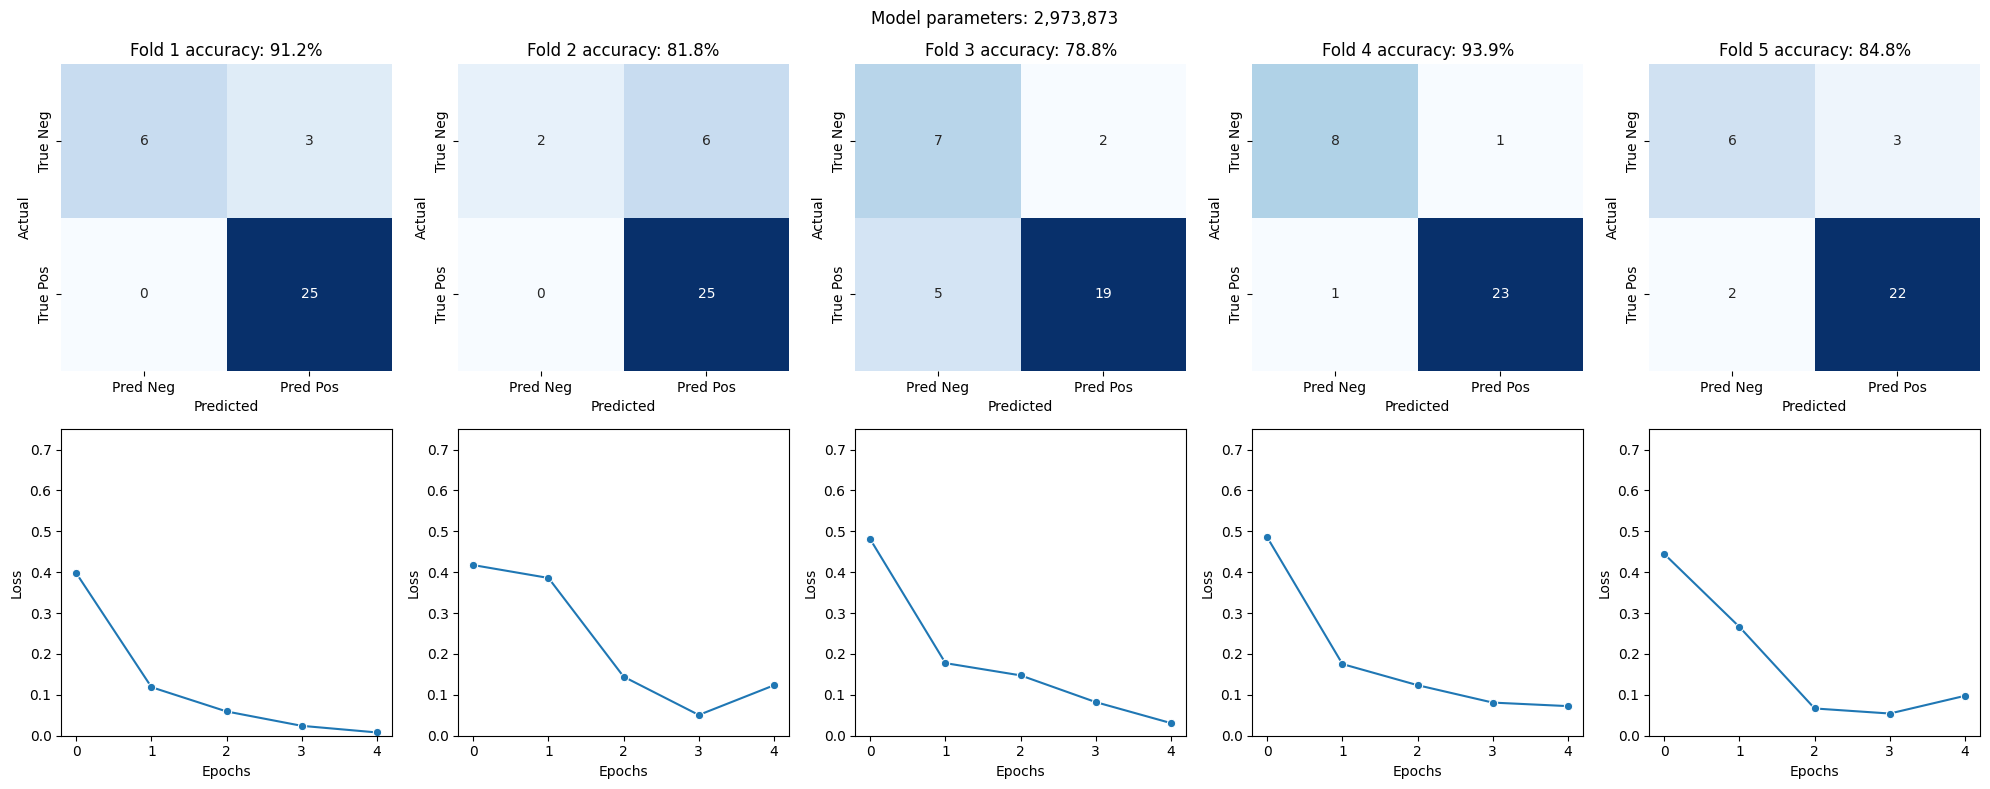

In [68]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(f'Model parameters: {model_params:,}')
axes = axes.flatten()

for i, (cm, acc) in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['True Neg', 'True Pos'])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_title(f'Fold {i+1} accuracy: {acc:>0.1f}%')
    
for i, train_loss in enumerate(train_losses, start=len(confusion_matrices)):
    sns.lineplot(x=np.arange(epochs), y=train_loss, ax=axes[i], marker='o')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].set_ylim(0, 0.75)

plt.tight_layout()
plt.show()